Importing libraries

In [ ]:
# !pip install imbalanced-learn
# !pip install requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler,OneHotEncoder,FunctionTransformer,RobustScaler, QuantileTransformer, PowerTransformer, Normalizer, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
import requests
import zipfile
import io


   ---------------------------------------- 0/5 [urllib3]
   -------- ------------------------------- 1/5 [idna]
   ------------------------ --------------- 3/5 [certifi]
   ---------------------------------------- 5/5 [requests]




[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Downlanding and marging databases

In [3]:

url="https://data.sa.gov.au/data/dataset/21386a53-56a1-4edf-bd0b-61ed15f10acf/resource/78d24425-6c14-426e-8895-d414c2a12521/download/2019-2023_data_sa_as_at_20240913.zip"
r=requests.get(url)
zip=zipfile.ZipFile(io.BytesIO(r.content))
file1=zip.open("2019-2023_DATA_SA_Casualty.csv")
file2=zip.open("2019-2023_DATA_SA_Crash.csv")
df=pd.read_csv(file1)
df2=pd.read_csv(file2)
df=pd.merge(df, df2, on="REPORT_ID")

Creating column is_fatal and droping unnecessary columns

In [4]:
unnecessary_columns=['Hospital', 'Postcode','LGA Name', 'Other Feat','Year','Traffic Ctrls','Entity Code','CSEF Severity','ACCLOC_X', 'ACCLOC_Y', 'UNIQUE_LOC','Position Type','Horizontal Align','Vertical Align','Helmet','Thrown Out', 'Month', 'Day','Crash Date Time','Total Cas', 'Total Fats', 'Total SI', 'Total MI', 'Unit Resp','REPORT_ID', 'UND_UNIT_NUMBER', 'CASUALTY_NUMBER', 'Road Surface','Suburb','Injury Extent']
df['is_fatal']=df['Injury Extent'].apply(lambda injury:1 if "Fatal" in str(injury) else 0)
df=df.drop(columns=unnecessary_columns)

Changing some cathegorical columns into numerical, and droping NA

In [5]:
df['DUI Involved']=df['DUI Involved'].apply(lambda DUI: 1 if DUI == 'Y' else 0)
df['Drugs Involved']=df['Drugs Involved'].apply(lambda Drugs: 1 if Drugs == 'Y' else 0)
df['Seat Belt']=df['Seat Belt'].replace({'Fitted - Worn': 1,'Child Restraint - Worn': 1,'Fitted - Unknown if Worn': 0,'Child Restraint - Not Worn': 0,'Fitted - Not Worn': 0, 'Not Applicable': 0,'Not Fitted': 0, 'Unknown': 0 })
df['Seat Belt']=df['Seat Belt'].fillna(0).astype(int)
df['AGE']=df['AGE'].replace('XXX', np.nan)
df['AGE']=df['AGE'].replace('XX', np.nan)
columns=df.columns.to_list()
df.to_csv('database.csv', index=False)

C:\Users\Matylda\AppData\Local\Temp\ipykernel_20788\1677509422.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Seat Belt']=df['Seat Belt'].replace({'Fitted - Worn': 1,'Child Restraint - Worn': 1,'Fitted - Unknown if Worn': 0,'Child Restraint - Not Worn': 0,'Fitted - Not Worn': 0, 'Not Applicable': 0,'Not Fitted': 0, 'Unknown': 0 })


Converting categorical variable into dummy variables

In [6]:
categorical_columns=['Casualty Type', 'Sex', 'Position In Veh',
                       'Stats Area', 'Time', 'Moisture Cond', 'Weather Cond', 'DayNight', 'Crash Type']
df=pd.get_dummies(df, columns=categorical_columns, drop_first=True)
df=df.dropna(subset=['AGE'])
df['AGE']=df['AGE'].astype(int)
y=df['is_fatal']
x=df.drop(columns=['is_fatal'])


Undersampling (there are many more non-fatal than fatal accidents) and splitting the data into training and testing sets

In [81]:
unders=RandomUnderSampler(random_state=42)
x_resampled, y_resampled=unders.fit_resample(x, y)
x_train, x_test, y_train, y_test=train_test_split(x_resampled, y_resampled, test_size=0.3, random_state=42)

Optimalization random state, n_estimators, min_splits and min leafs in Random forest model

In [82]:
random_states=[50,100,15,10,5,200]
n_estimators=[50,100,25,10]
min_splits=[2, 4, 6,8,10,12]
min_leafs=[1, 2, 3,4,5]
results=[]
best_acc=0.0

for random_state in random_states:
    for n in n_estimators:
        for split in min_splits:
            for leaf in min_leafs:
                model = RandomForestClassifier(
                    n_estimators=n, 
                    random_state=random_state, 
                    max_depth=6,
                    min_samples_split=split, 
                    min_samples_leaf=leaf
                )
                model.fit(x_train, y_train)
                y_pred=model.predict(x_test)
                accuracy=accuracy_score(y_test, y_pred)
                if(accuracy>best_acc):
                    best_acc=accuracy
                    best_n=n
                    best_state=random_state
                    best_split=split
                    best_leaf=leaf
model = RandomForestClassifier(
                    n_estimators=best_n, 
                    random_state=best_state, 
                    max_depth=6,
                    min_samples_split=best_split, 
                    min_samples_leaf=best_leaf
                )
model.fit(x_train, y_train)
y_pred=model.predict(x_test)
accuracy=accuracy_score(y_test, y_pred)
print("Random states", best_state)
print("n_estimators", best_n)
print("min_samples_split", best_split)
print("min_samples_leaf", best_leaf)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred)) 

Random states 15
n_estimators 50
min_samples_split 2
min_samples_leaf 1
Accuracy:  0.8282828282828283
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.78      0.82       147
           1       0.80      0.87      0.84       150

    accuracy                           0.83       297
   macro avg       0.83      0.83      0.83       297
weighted avg       0.83      0.83      0.83       297



Training (adding arguments: lass_weight="balanced",criterion='entropy',max_features="sqrt") to improve accuracy

In [83]:

model=RandomForestClassifier(n_estimators=50, random_state=15,max_depth=6,class_weight="balanced",criterion='entropy',max_features="sqrt",min_samples_split=2,min_samples_leaf=1)
model.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=6, n_estimators=50, random_state=15)

Checking accuracy

In [84]:
y_pred=model.predict(x_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy:  0.8383838383838383
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.82      0.83       147
           1       0.83      0.86      0.84       150

    accuracy                           0.84       297
   macro avg       0.84      0.84      0.84       297
weighted avg       0.84      0.84      0.84       297



The model returns two values for each sample in X_test: probabilities for is_Fatal=0 (not death) and is_Fatal=1 (death)

In [85]:
probabilities=model.predict_proba(x_test)
print("Probabilities of fatality in a crash with given conditions (x_test):",probabilities[:, 1])

Probabilities of fatality in a crash with given conditions (x_test): [0.46208803 0.33970732 0.57153464 0.42739838 0.60476021 0.56191084
 0.3290688  0.56408019 0.31513508 0.66203182 0.51916002 0.57400804
 0.3844746  0.51529326 0.67225642 0.65604418 0.6290838  0.63325312
 0.34004528 0.55320296 0.4449975  0.61840399 0.62670574 0.55401382
 0.61186711 0.35013656 0.50307606 0.63200912 0.44304406 0.52350231
 0.53203105 0.3915827  0.59220626 0.6381711  0.5521632  0.72043958
 0.39137312 0.52158568 0.64426218 0.3282735  0.56336121 0.44553307
 0.46263332 0.52949171 0.67615684 0.36324136 0.49974459 0.55961216
 0.63022607 0.49813861 0.43974293 0.43303447 0.55275219 0.46947193
 0.35281487 0.63395953 0.44379462 0.63578868 0.41399108 0.4464376
 0.43040344 0.42975672 0.51714683 0.33632177 0.42264312 0.3880743
 0.65595495 0.51848633 0.6357941  0.58913081 0.44707425 0.33600174
 0.41659906 0.49073837 0.40552977 0.4793223  0.57937553 0.36551949
 0.3844746  0.72251728 0.60585561 0.46111513 0.31513508 0.6891

Creating dataframe that includes features importance

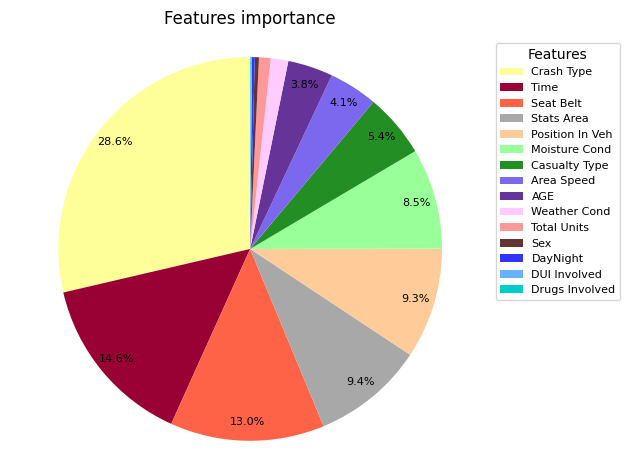

In [103]:
features = pd.Series(model.feature_importances_, index=x_train.columns)


grouped_features = {}
for c in columns:
    if c=='is_fatal':
        continue
    if c in categorical_columns:
        grouped_features[c]=features.filter(like=c).sum()
    else:
        grouped_features[c]=features[c]

grouped_features=pd.DataFrame.from_dict(grouped_features, orient='index', columns=['Importance'])
grouped_features=grouped_features.sort_values(by='Importance', ascending=False)
# grouped_features.to_csv('features.csv', index=False)
# print(grouped_features)
colors = ['#663399','#7B68EE','#238E23','#ffff99','#66B3FF','#3333ff','#00cccc', '#99FF99', '#FFCC99', '#FF6347', '#663333','#A8A8A8','#990033','#FF9999', '#ffccff',]
sorted_features = sorted(grouped_features.index)
zip = __builtins__.zip
feature_colors = {name: color for name, color in zip(sorted_features, colors)}

def per(pct):
    return ('%.1f%%' % pct) if pct > 2 else ''
plt.pie(grouped_features["Importance"], labels=None,autopct=per,startangle=90,pctdistance=0.9, colors=[feature_colors[name] for name in grouped_features.index],textprops={'fontsize': 8})

plt.legend(grouped_features.index, title="Features", loc='upper left', fontsize=8,bbox_to_anchor=(1, 1))
plt.axis('equal') 
plt.title('Features importance',pad=10) 
plt.tight_layout()
plt.show() 


Oversampling

In [87]:

smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x, y)
# x_train2 = pd.DataFrame(x_resampled, columns=x.columns)
x_train2, x_test2, y_train2, y_test2=train_test_split(x_resampled, y_resampled, test_size=0.3, random_state=42)

optimalization random state, n_estimators, min_splits and min leafs in Random forest model

In [88]:
random_states=[50,100,15,10,5]
n_estimators=[50,100,25,10]
min_splits=[2, 4, 6,8,10]
min_leafs=[1, 2, 3,4,5]
results=[]
best_acc=0.0

for random_state in random_states:
    for n in n_estimators:
        for split in min_splits:
            for leaf in min_leafs:
                model = RandomForestClassifier(
                    n_estimators=n, 
                    random_state=random_state, 
                    class_weight="balanced", 
                    max_features="sqrt",
                    max_depth=6,
                    criterion='entropy',
                    min_samples_split=split, 
                    min_samples_leaf=leaf
                )
                model.fit(x_train2, y_train2)
                y_pred2=model.predict(x_test2)
                accuracy=accuracy_score(y_test2, y_pred2)
                if(accuracy>best_acc):
                    best_acc=accuracy
                    best_n=n
                    best_state=random_state
                    best_split=split
                    best_leaf=leaf
model = RandomForestClassifier(
                    n_estimators=best_n, 
                    random_state=best_state, 
                    max_depth=6,
                    min_samples_split=best_split, 
                    min_samples_leaf=best_leaf
                )
model.fit(x_train2, y_train2)
y_pred2=model.predict(x_test2)
accuracy=accuracy_score(y_test2, y_pred2)
print("Random states", best_state)
print("n_estimators", best_n)
print("min_samples_split", best_split)
print("min_samples_leaf", best_leaf)
print("Accuracy: ", accuracy_score(y_test2, y_pred2))
print("Classification Report:\n", classification_report(y_test2, y_pred2))  

Random states 5
n_estimators 50
min_samples_split 10
min_samples_leaf 1
Accuracy:  0.8866998432067625
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.83      0.88      7331
           1       0.85      0.95      0.89      7338

    accuracy                           0.89     14669
   macro avg       0.89      0.89      0.89     14669
weighted avg       0.89      0.89      0.89     14669



Training (adding arguments: lass_weight="balanced",criterion='entropy',max_features="sqrt") to improve accuracy

In [89]:
model2=RandomForestClassifier(n_estimators=100, random_state=15,max_depth=6,class_weight="balanced",criterion='entropy',max_features="sqrt",min_samples_split=4,min_samples_leaf=1)
model2.fit(x_train2, y_train2)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=6, min_samples_split=4, random_state=15)

Checking accuracy

In [37]:
y_pred2=model2.predict(x_test2)
print("Accuracy: ", accuracy_score(y_test2, y_pred2))
print("Classification Report:\n", classification_report(y_test2, y_pred2))

Accuracy:  0.8751789488035995
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.81      0.87      7331
           1       0.83      0.94      0.88      7338

    accuracy                           0.88     14669
   macro avg       0.88      0.88      0.87     14669
weighted avg       0.88      0.88      0.87     14669



Creating dataframe that includes features importance

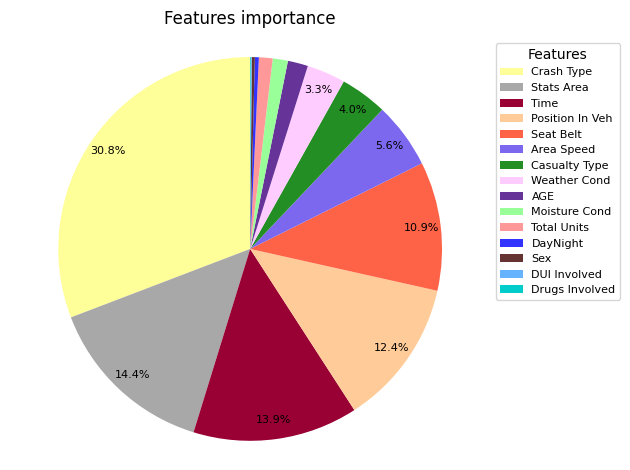

In [105]:
features = pd.Series(model2.feature_importances_, index=x_train2.columns)


grouped_features = {}
for c in columns:
    if c=='is_fatal':
        continue
    if c in categorical_columns:
        grouped_features[c]=features.filter(like=c).sum()
    else:
        grouped_features[c]=features[c]
        

grouped_features=pd.DataFrame.from_dict(grouped_features, orient='index', columns=['Importance'])
grouped_features=grouped_features.sort_values(by='Importance', ascending=False)
colors = ['#663399','#7B68EE','#238E23','#ffff99','#66B3FF','#3333ff','#00cccc', '#99FF99', '#FFCC99', '#FF6347', '#663333','#A8A8A8','#990033','#FF9999', '#ffccff',]
sorted_features = sorted(grouped_features.index)
zip = __builtins__.zip
feature_colors = {name: color for name, color in zip(sorted_features, colors)}

def per(pct):
    return ('%.1f%%' % pct) if pct > 2 else ''
plt.pie(grouped_features["Importance"], labels=None,autopct=per,startangle=90,pctdistance=0.9, colors=[feature_colors[name] for name in grouped_features.index],textprops={'fontsize': 8})

plt.legend(grouped_features.index, title="Features", loc='upper left', fontsize=8,bbox_to_anchor=(1, 1))
plt.axis('equal') 
plt.title('Features importance',pad=10) 
plt.tight_layout()
plt.show() 